In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
labels_targets = torch.load('test_labels_targets.pt')
outputs_class = torch.load('test_outputs_class.pt')
outputs_targets = torch.load('test_outputs_targets.pt')
mean_scale = torch.load('../hyperk_img/mean_scale.pt')

labels = labels_targets[:,0]
targets = labels_targets[:,1:5]

labels_targets.shape, outputs_class.shape, outputs_targets.shape, labels.shape, targets.shape

/tmp/ipykernel_611622/4282087692.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels_targets = torch.load('test_labels_targets.pt')
/tmp/ipykernel_611622/4282087692.p

((5000, 8), (5000, 2), (5000, 4), (5000,), (5000, 4))

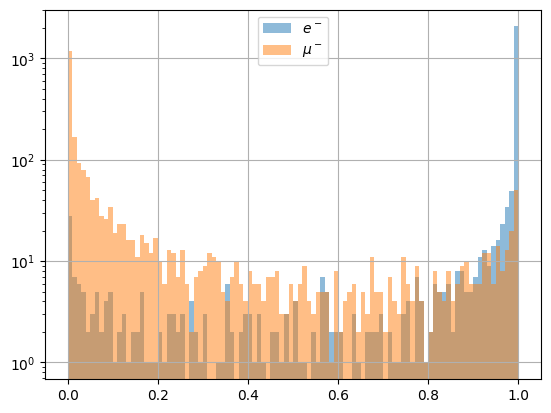

In [3]:
plt.hist(outputs_class[:,0][labels==0], bins=100, alpha=0.5, label=r'$e^-$')
plt.hist(outputs_class[:,0][labels==1], bins=100, alpha=0.5, label=r'$\mu^-$')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()

In [4]:
from torchmetrics.classification import BinaryAccuracy
import torch
accuracy_calc = BinaryAccuracy(threshold=0.5)
acc=accuracy_calc(torch.tensor(outputs_class[:,1]), torch.tensor(labels))
print('Accuracy: {:.1f} %'.format(acc*100.))

Accuracy: 90.0 %


In [5]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(labels, outputs_class[:,1])
auc=roc_auc_score(labels, outputs_class[:,1])


<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

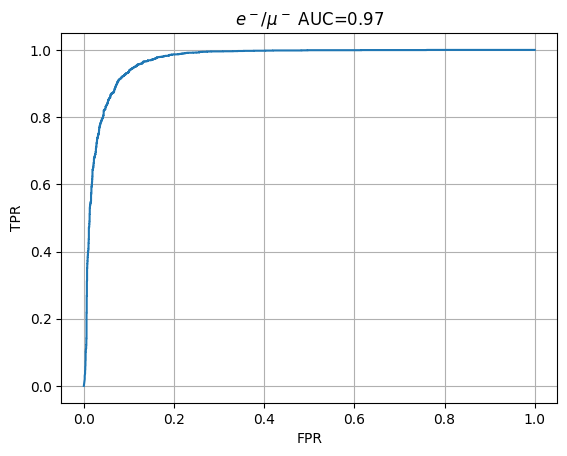

In [6]:
title=r'$e^-/\mu^-$ AUC={:.2f}'.format(auc)
plt.title(title)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.ylabel

In [7]:
### MSE ###
import torch.nn.functional as F
print('MSE')
variables=['Energy', 'Position:X', 'Position:Y', 'Position:Z']
for i in range(4):
    print('{:s} {:.4f}'.format(variables[i], float(F.mse_loss(torch.tensor(targets[:,i]), torch.tensor(outputs_targets[:,i])))))

MSE
Energy 0.0143
Position:X 0.0208
Position:Y 0.0187
Position:Z 0.0191


### Comparison of the outputs and the normalised variables ###

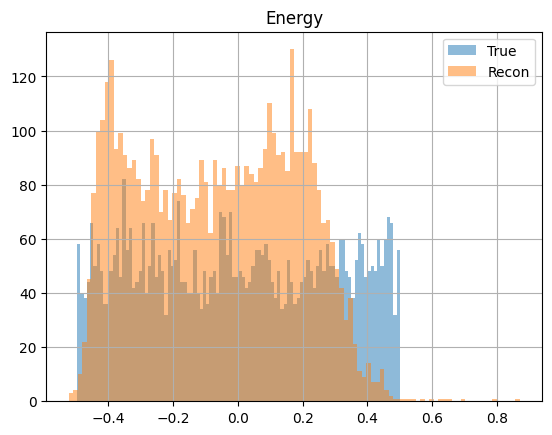

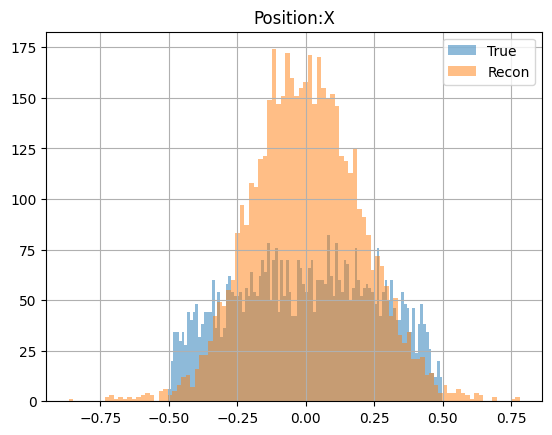

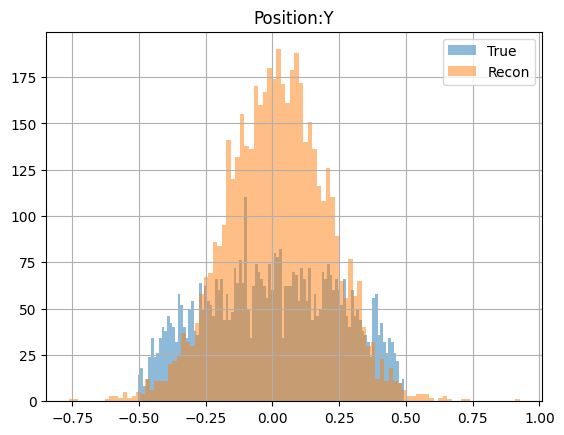

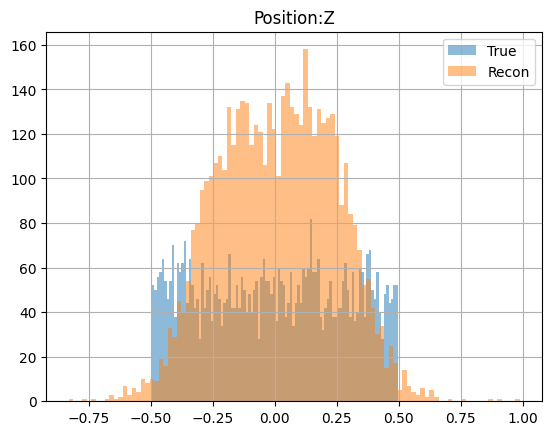

In [8]:
titles = ['Energy', 'Position:X', 'Position:Y', 'Position:Z']
for i in range(len(titles)):
    plt.title(titles[i])
    plt.hist(targets[:,i], bins=100, alpha=0.5, label='True')
    plt.hist(outputs_targets[:,i], bins=100, alpha=0.5, label='Recon')
    plt.grid()
    plt.legend()
    plt.show()


#### Scale to orgiginal ####

In [9]:
targets_scaled = targets*mean_scale['targets']['scale'][:4].numpy()+mean_scale['targets']['mean'][:4].numpy()
recons_scaled = outputs_targets*mean_scale['targets']['scale'][:4].numpy()+mean_scale['targets']['mean'][:4].numpy()

In [10]:
## rectangular coordinate to spherical coordinate
def rec2sph(rec):
    print(rec[2].shape)
    r=np.linalg.norm(rec,ord=2,axis=0)
    print(r.shape)
    theta=np.arccos(rec[2]/r)
    rho=np.linalg.norm(rec[:2], ord=2, axis=0)
    phi=np.arccos(rec[0]/rho)
    #phi=phi*-1 if rec[1]<0 else phi
    phi=np.where(rec[1]<0, phi, phi*-1)
    #return np.array([r,theta,phi])
    return r,theta,phi

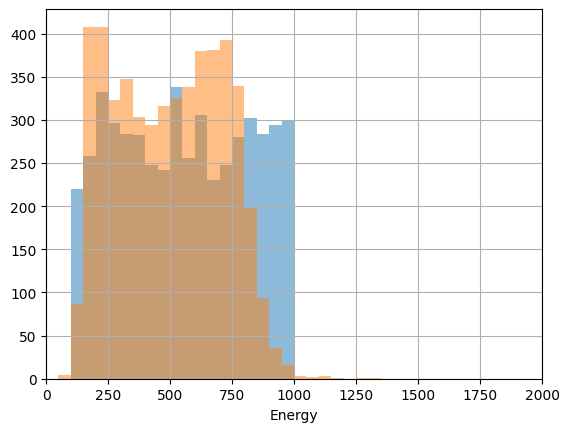

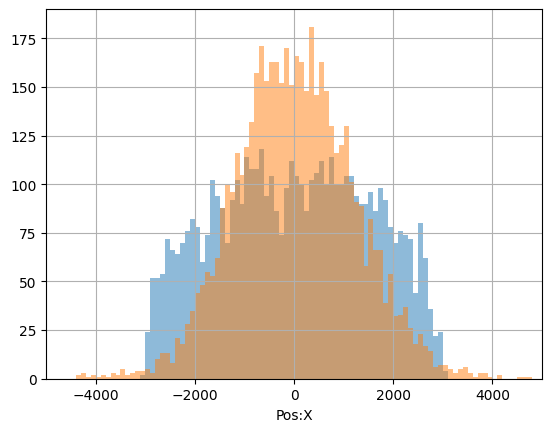

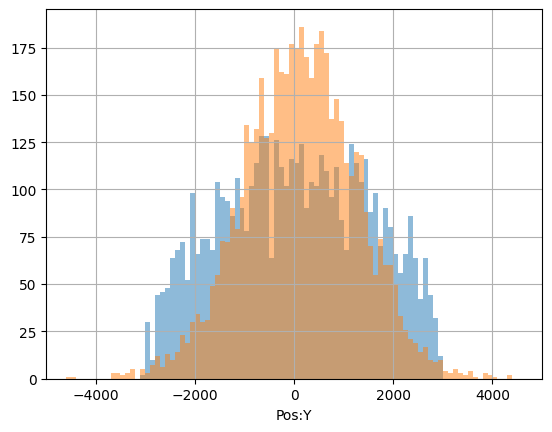

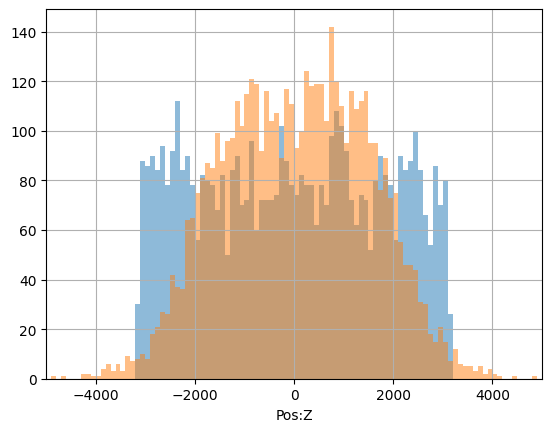

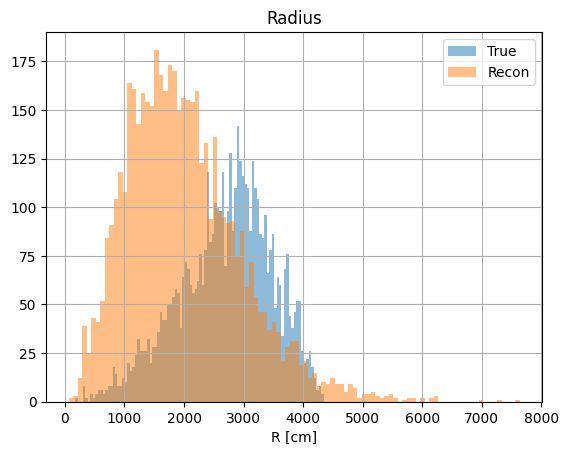

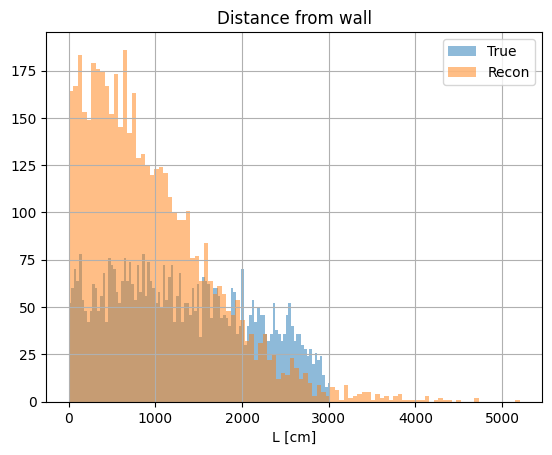

(5000,)
(5000,)
(5000,)
(5000,)


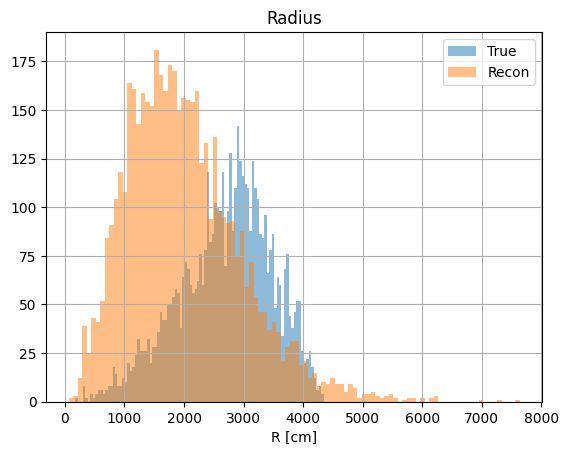

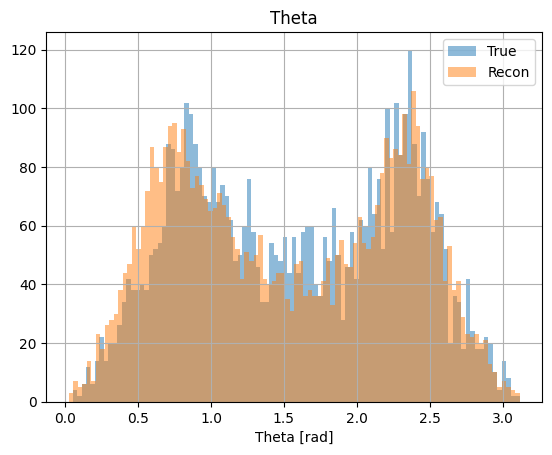

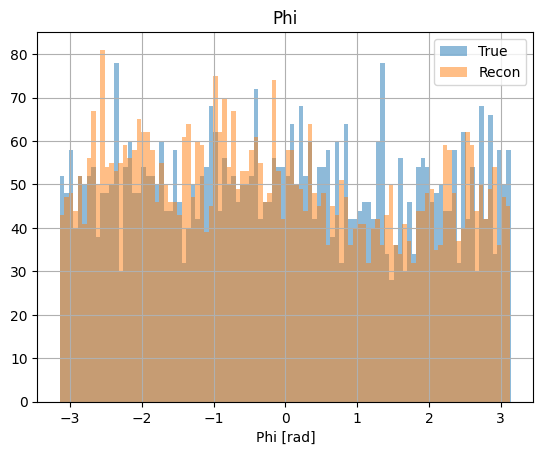

In [11]:
targets

variables = ['Energy', 'Pos:X', 'Pos:Y', 'Pos:Z']
bin_widths={'Type':1, 'Energy':50, 'Pos:X':100, 'Pos:Y':100, 'Pos:Z':100, 'Dir:Theta':np.pi/18, 'Dir:Phi':np.pi/18}
ranges = {'Type':[-1,2], 'Energy':[0,2000], 'Pos:X':[-5000,5000], 'Pos:Y':[-5000,5000], 'Pos:Z':[-5000,5000], 'Dir:Theta':[-np.pi,np.pi*2], 'Dir:Phi':[-np.pi*2, np.pi*2]} 
for i in range(len(variables)):
    variable=variables[i]

    bins=int((ranges[variable][1]-ranges[variable][0])/bin_widths[variable])
    plt.hist(targets_scaled[:,i], bins=bins, range=ranges[variable], alpha=0.5, label='True')
    plt.hist(recons_scaled[:,i], bins=bins, range=ranges[variable], alpha=0.5, label='Recon')
    plt.xlabel(variable)
    #plt.ylabel('Recon - True')
    #plt.ylim([-500,500])
    plt.xlim([ranges[variable][0],ranges[variable][1]])
    plt.grid()
    plt.show()


    if variable=='Pos:Z':
        r_true=np.linalg.norm(targets_scaled[:,1:], ord=2, axis=1)
        r_recon=np.linalg.norm(recons_scaled[:,1:], ord=2, axis=1)
        plt.title('Radius')
        plt.hist(r_true, bins=100, alpha=0.5, label='True')
        plt.hist(r_recon, bins=100, alpha=0.5, label='Recon')
        plt.xlabel('R [cm]')
        plt.grid()
        plt.legend()
        plt.show()

        l_true=np.linalg.norm(targets_scaled[:,1:2], ord=2, axis=1)
        l_recon=np.linalg.norm(recons_scaled[:,1:2], ord=2, axis=1)
        plt.title('Distance from wall')
        plt.hist(l_true, bins=100, alpha=0.5, label='True')
        plt.hist(l_recon, bins=100, alpha=0.5, label='Recon')
        plt.xlabel('L [cm]')
        plt.grid()
        plt.legend()
        plt.show()

        rec_true = [targets_scaled[:,1], targets_scaled[:,2], targets_scaled[:,3]] 
        posR_true,posTheta_true,posPhi_true = rec2sph(rec_true)
        rec_recon = [recons_scaled[:,1], recons_scaled[:,2], recons_scaled[:,3]] 
        posR_recon,posTheta_recon,posPhi_recon = rec2sph(rec_recon)

        plt.title('Radius')
        plt.hist(posR_true, bins=100, alpha=0.5, label='True')
        plt.hist(posR_recon, bins=100, alpha=0.5, label='Recon')
        plt.xlabel('R [cm]')
        plt.grid()
        plt.legend()
        plt.show()

        plt.title('Theta')
        plt.hist(posTheta_true, bins=100, alpha=0.5, label='True')
        plt.hist(posTheta_recon, bins=100, alpha=0.5, label='Recon')
        plt.xlabel('Theta [rad]')
        plt.grid()
        plt.legend()
        plt.show()

        plt.title('Phi')
        plt.hist(posPhi_true, bins=100, alpha=0.5, label='True')
        plt.hist(posPhi_recon, bins=100, alpha=0.5, label='Recon')
        plt.xlabel('Phi [rad]')
        plt.grid()
        plt.legend()
        plt.show()


### Functions ###

In [12]:
# function to check energy, position dependency
def binning(target, x, bin_width, bin_range):
    bins = int((bin_range[1]-bin_range[0])/bin_width)
    binned = []
    for i in range(bins):
        binned.append(x[((target>=(bin_range[0]+i*bin_width))&(target<(bin_range[0]+(i+1)*bin_width)))])

    return binned

In [13]:
def gaussian(x, amp, loc, sig):
    return amp*np.exp(-np.power(x - loc, 2.) / (2 * np.power(sig, 2.)))

### Energy resolution ###
* Energy resolution depends on the energy

<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_611622/1283688979.py:23: SyntaxWarning: invalid escape sequence '\s'
  label='$\sigma$={:.1f}%'.format(p[2])
/tmp/ipykernel_611622/1283688979.py:26: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta$E%')
/tmp/ipykernel_611622/1283688979.py:35: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_{E}$ %')


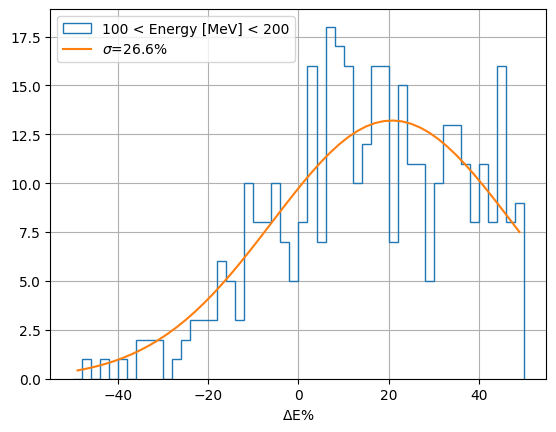

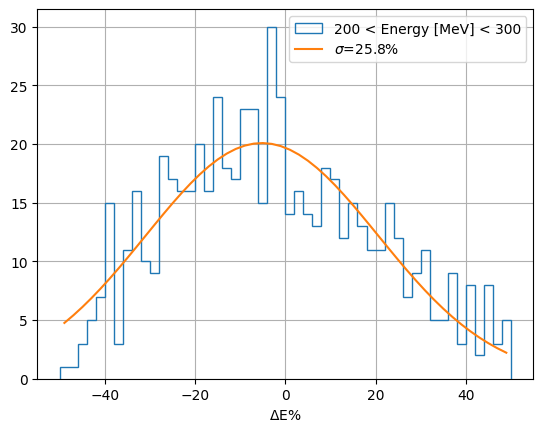

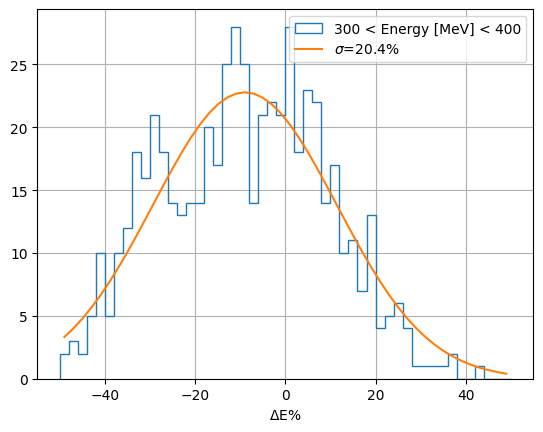

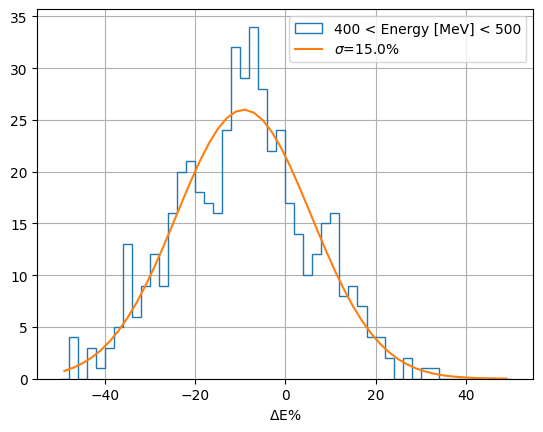

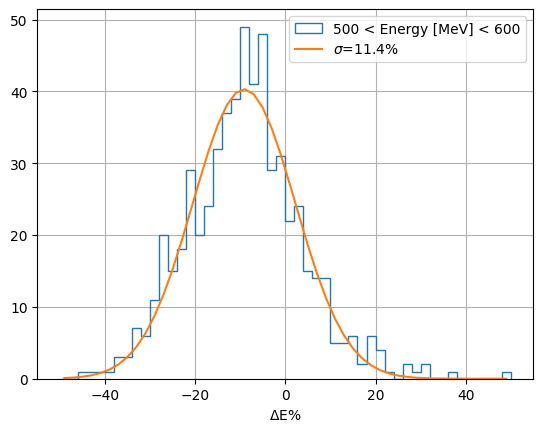

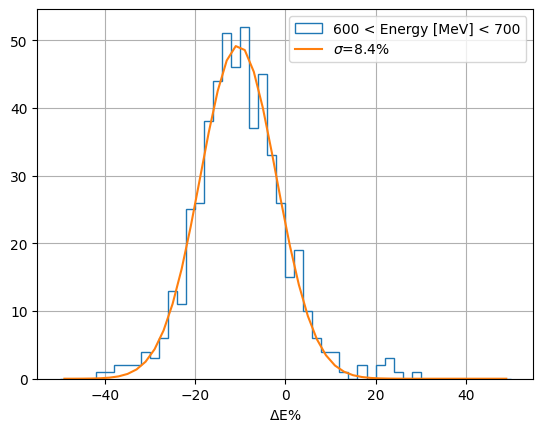

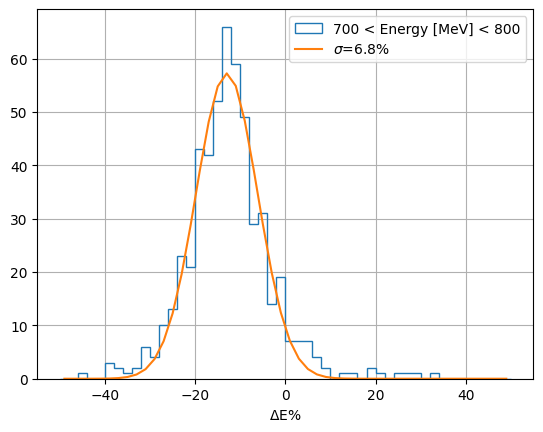

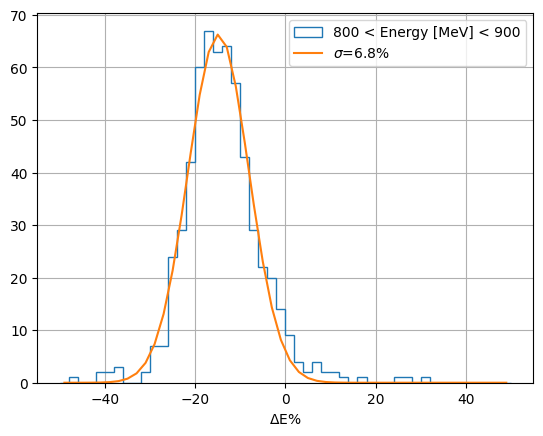

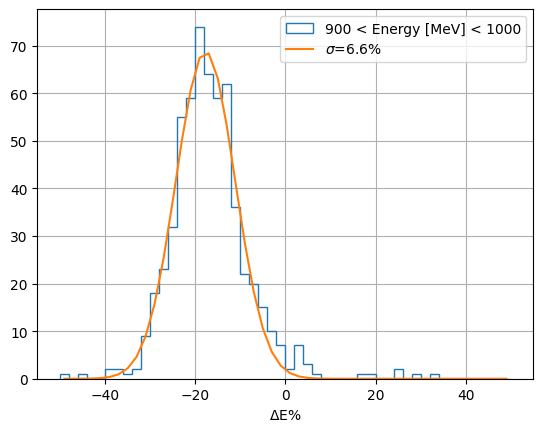

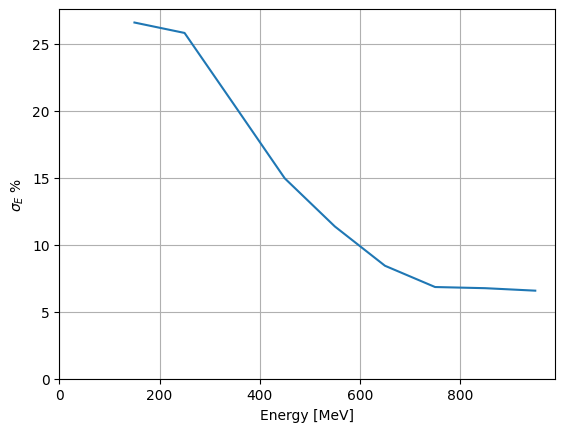

In [14]:
bias=(recons_scaled-targets_scaled)/targets_scaled * 100. # %
# Energy resolution
#delE=difference[:,1]
delE=bias[:,0]

energy_range=[100,1000]
bin_width=100
delE_binned=binning(targets_scaled[:,0], delE, bin_width=bin_width, bin_range=energy_range)

sigma_E=[]
E=[]
for i in range(len(delE_binned)):
    lower=energy_range[0]+bin_width*i
    higher=energy_range[0]+bin_width*(i+1)
    E.append(lower+(higher-lower)/2.)
    label='{:d} < Energy [MeV] < {:d}'.format(lower,higher)
    hist_delE=plt.hist(delE_binned[i], bins=50, range=[-50,50], label=label , histtype='step', lw=2, density=False)
    x_hist_delE = (hist_delE[1][1:]+hist_delE[1][0:-1])/2.
    y_hist_delE = hist_delE[0]
    p0 = [y_hist_delE.max(), delE.mean(), delE.std()]
    p, pcov = curve_fit(gaussian, x_hist_delE, y_hist_delE, p0=p0)
    fit=gaussian(x_hist_delE, p[0], p[1], p[2])
    label='$\sigma$={:.1f}%'.format(p[2])
    sigma_E.append(p[2])
    plt.plot(x_hist_delE, fit, label=label)
    plt.xlabel('$\Delta$E%')
    plt.legend()
    plt.grid()
    plt.show()

plt.plot(E,sigma_E)
plt.xlim([0.,None])
plt.ylim([0.,None])
plt.xlabel('Energy [MeV]')
plt.ylabel('$\sigma_{E}$ %')
plt.grid()
plt.show()

### Vertex resolution ###
* The resolution is calculated by np.std(). Try to calculate by fitting with gaussian.
* The resolution depends on the position.

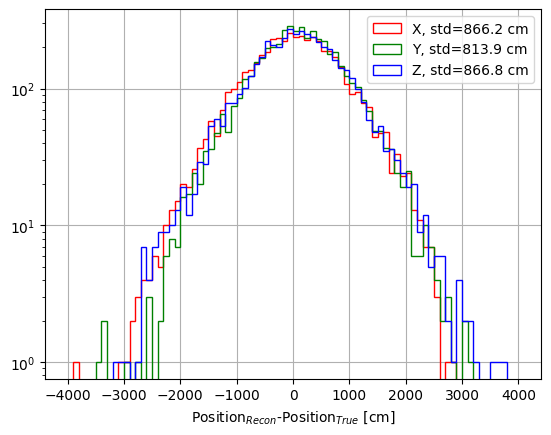

In [15]:

distance = recons_scaled[:,1:]-targets_scaled[:,1:]
plt.hist(distance[:,0], bins=80, range=[-4000,4000], label='X, std={:.1f} cm'.format(distance.std(axis=0)[0]), color='red', histtype='step', lw=2)
plt.hist(distance[:,1], bins=80, range=[-4000,4000], label='Y, std={:.1f} cm'.format(distance.std(axis=0)[1]), color='green', histtype='step', lw=2)
plt.hist(distance[:,2], bins=80, range=[-4000,4000], label='Z, std={:.1f} cm'.format(distance.std(axis=0)[2]), color='blue', histtype='step', lw=2)
plt.yscale('log')
plt.xlabel(r'Position$_{Recon}$-Position$_{True}$ [cm]')
plt.legend()
plt.grid()
plt.show()

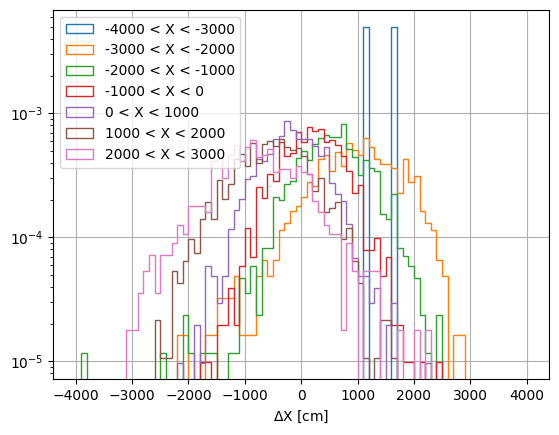

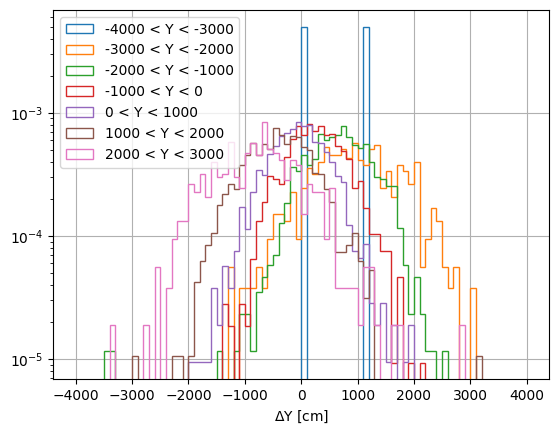

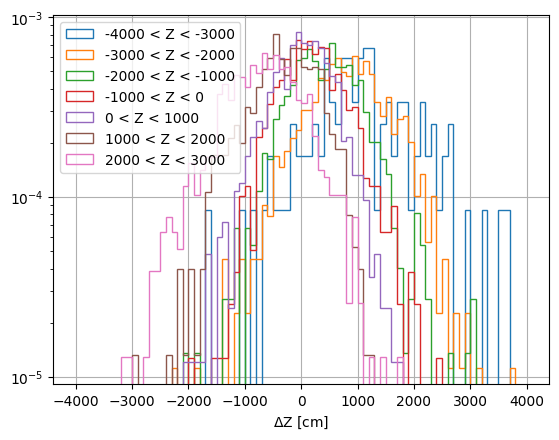

In [16]:
distance_x_binned=binning(targets_scaled[:,1], distance[:,0], bin_width=1000, bin_range=[-4000,4000])
for i in range(len(distance_x_binned)-1):
    lower=-4000+1000*i
    higher=-4000+1000*(i+1)
    label='{:d} < X < {:d}'.format(lower,higher)
    plt.hist(distance_x_binned[i], bins=80, range=[-4000,4000], label=label , histtype='step', lw=2, density=True)
plt.grid()
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\Delta$X [cm]')
plt.show()

distance_y_binned=binning(targets_scaled[:,2], distance[:,1], bin_width=1000, bin_range=[-4000,4000])
for i in range(len(distance_x_binned)-1):
    lower=-4000+1000*i
    higher=-4000+1000*(i+1)
    label='{:d} < Y < {:d}'.format(lower,higher)
    plt.hist(distance_y_binned[i], bins=80, range=[-4000,4000], label=label , histtype='step', lw=2, density=True)
plt.grid()
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\Delta$Y [cm]')
plt.show()

distance_z_binned=binning(targets_scaled[:,3], distance[:,2], bin_width=1000, bin_range=[-4000,4000])
for i in range(len(distance_z_binned)-1):
    lower=-4000+1000*i
    higher=-4000+1000*(i+1)
    label='{:d} < Z < {:d}'.format(lower,higher)
    plt.hist(distance_z_binned[i], bins=80, range=[-4000,4000], label=label , histtype='step', lw=2, density=True)
plt.grid()
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\Delta$Z [cm]')
plt.show()